## 1. Cargando los datos

In [1]:
# Packages needed
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
from scipy.stats import chisquare
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# Styles for Matplotlib
plt.style.use('ggplot')

Los datos vienen en archivos json que se acumulan a través de un servicio IoT, con una infraestructura en azure diariamente. La periodicidad de los datos es 10 minutos cada variable.

In [2]:
# Loading the iot json file as dataframe
df = pd.read_json("data/data.json", lines=True)

In [3]:
# Shape for Historical DF
df.shape

(509067, 8)

In [4]:
# Showing a sample for Historical DF
df.sample(5)

,NodeId,ApplicationUri,Value,EventProcessedUtcTime,PartitionId,EventEnqueuedUtcTime,IoTHub,campo
488830,urn:honeywell-com:experion:opcuaserver#s=exp_o...,urn:honeywell-com:experion:opcuaserver,"{'Value': 168.55996704101562, 'SourceTimestamp...",2023-09-14T19:12:56.8125663Z,3,2023-09-14T19:12:56.5780000Z,"{'MessageId': None, 'CorrelationId': None, 'Co...",OCELOTE
447550,urn:honeywell-com:experion:opcuaserver#s=exp_o...,urn:honeywell-com:experion:opcuaserver,"{'Value': 280.6, 'SourceTimestamp': '2023-09-1...",2023-09-14T17:34:44.3776147Z,3,2023-09-14T17:34:44.1960000Z,"{'MessageId': None, 'CorrelationId': None, 'Co...",OCELOTE
52238,urn:honeywell-com:experion:opcuaserver#s=exp_o...,urn:honeywell-com:experion:opcuaserver,"{'Value': 57.19200897216797, 'SourceTimestamp'...",2023-09-14T01:59:32.3185075Z,3,2023-09-14T01:59:32.1010000Z,"{'MessageId': None, 'CorrelationId': None, 'Co...",OCELOTE
42296,urn:honeywell-com:experion:opcuaserver#s=exp_o...,urn:honeywell-com:experion:opcuaserver,"{'Value': 123.5, 'SourceTimestamp': '2023-09-1...",2023-09-14T01:36:31.8612224Z,3,2023-09-14T01:36:31.6750000Z,"{'MessageId': None, 'CorrelationId': None, 'Co...",OCELOTE
134169,urn:honeywell-com:experion:opcuaserver#s=exp_o...,urn:honeywell-com:experion:opcuaserver,"{'Value': 34.699999999999996, 'SourceTimestamp...",2023-09-14T05:12:18.2022486Z,3,2023-09-14T05:12:17.9650000Z,"{'MessageId': None, 'CorrelationId': None, 'Co...",OCELOTE


## 2. Calidad de datos

Revisión de los tipos de las variables

In [5]:
# Datatypes for Historical DF
df.dtypes

NodeId                   object
ApplicationUri           object
Value                    object
EventProcessedUtcTime    object
PartitionId               int64
EventEnqueuedUtcTime     object
IoTHub                   object
campo                    object
dtype: object

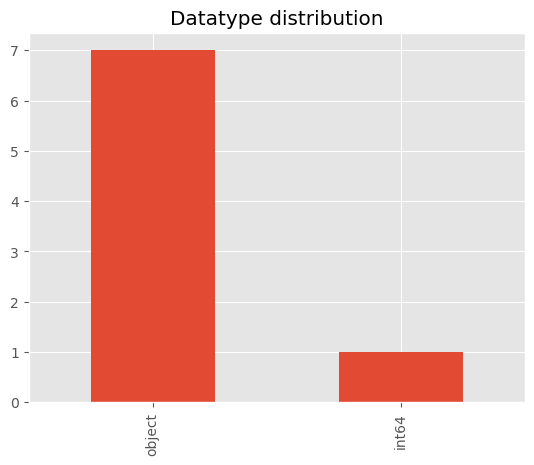

In [6]:
# Showing column types
df.dtypes.value_counts().plot.bar()
plt.title("Datatype distribution")
plt.show()

### Datos duplicados

La columna *NodeId* es el identificador de cada variable del dispositivo, mientras que *EventProcessedUtcTime* es el instante de tiempo en el que fue reportada. Con el fin de detectar correctamente cuántos registros están duplicados, debemos buscar cuáles registros comparten estas dos caracteristicas, ya que esto implicaría que se hizo el mismo reporte más de una vez. Por lo tanto, se procede a eliminar las variables repetidas con los mismos tiempos.

In [7]:
# Dropping Duplicates by NodeId and EventPRocessedUtcTime
df = df.drop_duplicates(['NodeId','EventProcessedUtcTime'])
df.shape

(508242, 8)

### Datos como diccionarios

Dos de las columnas vienen en diccionarios donde se encuentra la información y valor de las variables.

In [8]:
# Value Dictionary sample
df['Value'].iloc[0]

{'Value': 8.3, 'SourceTimestamp': '2023-09-14T00:00:23.1010154Z'}

In [9]:
# IoTHub Dictionary sample
df['IoTHub'].iloc[0]

{'MessageId': None,
 'CorrelationId': None,
 'ConnectionDeviceId': 'IE-OCE-HCL-PRD-IIOT',
 'ConnectionDeviceGenerationId': '637880767033430046',
 'EnqueuedTime': '2023-09-14T00:00:01.3740000Z'}

Estos datos son importantes, por lo tanto se procede a aplanar los diccionarios como columnas del dataframe para facilitar el uso de estas. 

In [10]:
new_cols = []

def dictionary_to_cols(df, col):
    variables_value = pd.json_normalize(df[col])
    for var in variables_value:
        new_cols.append(var)
        df[var] = variables_value[var]
    return df

# Adding dictionary keys as dataframe cols
df = dictionary_to_cols(df, 'Value')
df = dictionary_to_cols(df, 'IoTHub')

df = df.drop(['IoTHub'],axis=1)

In [11]:
# New cols taken from dictionaries
df[new_cols].sample(5)

,Value,SourceTimestamp,Value.Value,Value.DisplayName,Value.Description,MessageId,CorrelationId,ConnectionDeviceId,ConnectionDeviceGenerationId,EnqueuedTime
259671,695.862610,2023-09-14T09:59:53.301032Z,NaN,NaN,NaN,None,None,IE-OCE-HCL-PRD-IIOT,637880767033430046,2023-09-14T09:59:26.9890000Z
167745,716.300000,2023-09-14T06:25:04.0002902Z,NaN,NaN,NaN,None,None,IE-OCE-HCL-PRD-IIOT,637880767033430046,2023-09-14T06:24:37.5830000Z
130981,0.976439,2023-09-14T04:54:36.9005934Z,NaN,NaN,NaN,None,None,IE-OCE-HCL-PRD-IIOT,637880767033430046,2023-09-14T04:54:12.9820000Z
382545,50.710537,2023-09-14T14:58:46.1004732Z,NaN,NaN,NaN,None,None,IE-OCE-HCL-PRD-IIOT,637880767033430046,2023-09-14T14:58:24.0420000Z
340235,314.177032,2023-09-14T13:20:28.3001804Z,NaN,NaN,NaN,None,None,IE-OCE-HCL-PRD-IIOT,637880767033430046,2023-09-14T13:20:05.3740000Z


### Datos nulos

Para nuestro analisis es vital analizar el valor de las variables de los dispositivos, con el fin de predecir en qué momento un dispositivo puede empezar a fallar. Por esto borramos los registros que no tengan valor, dado que son pocos en comparación al dataset total.

In [12]:
# Dropping rows with no Value
df = df.dropna(subset=['Value'])
df.shape

(501048, 16)

Además podemos observar que algúnas columnas no presentan información, teniendo todos sus valores en nulo, por lo tanto serán eliminadas.

In [13]:
null_cols = []
# Searching null columns
for column in df:
    if df[column].isnull().any():
        null_cols.append(column)
# Removing null columns
df = df.drop(null_cols, axis=1)
print("Columnas eliminadas:", null_cols)

Columnas eliminadas: ['Value.Value', 'Value.DisplayName', 'Value.Description', 'MessageId', 'CorrelationId']


### Datos Concatenados

Podemos observar que la columna *'NodeId'* presenta datos concatenados, como el id del campo, id de la variable y el id del pozo. Por lo tanto es necesario limpiarla dado que vienen con información redundante y separar estos datos.

In [14]:
# Showing a sample for 'NodeId'
df['NodeId'].iloc[1]

'urn:honeywell-com:experion:opcuaserver#s=exp_oce%3aoce_86h_i_mot.pv'

Para este ejemplo podemos observar que para el campo **exp_oce** se midió la variable **i_mot.pv** del pozo **aoce_86h**

In [15]:
# Methods needed to extract 'variable' and 'pozo'
def process_nodeid(x):
    index = 0
    for i in range(len(x)):
        if bool(re.search(r'\d', x[i])):
            index = i
    rta = []
    for j in x[index:]:
        if not bool(re.search(r'\d', j)):
            rta.append(j+'_')
    rta= ''.join(rta)
    if len(rta)>1:
        if rta[-1] == '_':
            rta = rta[:-1]
    return rta

def process_yac(x):
    index = 0
    for i in range(len(x)):
        if bool(re.search(r'\d', x[i])) and '.pv' not in x[i]:
            index = i
    rta = []
    for j in x[:index+1]:
        rta.append(j+'_')
    rta= ''.join(rta)
    if rta[-1] == '_':
        rta = rta[:-1]
    return rta

In [16]:
df['Pozo'] = df['NodeId'].str.split('=').apply(lambda x: x[1]).str.split('%3').apply(lambda x: x[1]).str.split('_').apply(lambda x : process_yac(x))
df['Variable'] = df['NodeId'].str.split('=').apply(lambda x: x[1]).str.split('%3').apply(lambda x: x[1]).str.split('_').apply(lambda x : process_nodeid(x))

In [17]:
# New Variables
df[['NodeId', 'Variable', 'Pozo']].sample(5)

,NodeId,Variable,Pozo
116329,urn:honeywell-com:experion:opcuaserver#s=exp_o...,i_mot.pv,aoce_87h
344858,urn:honeywell-com:experion:opcuaserver#s=exp_o...,torq.pv,aoce_80h
108938,urn:honeywell-com:experion:opcuaserver#s=exp_o...,act_net_oil.pv,acor_026
446948,urn:honeywell-com:experion:opcuaserver#s=exp_o...,i_mot.pv,aoce_017
455795,urn:honeywell-com:experion:opcuaserver#s=exp_o...,torq.pv,aoce_119


### Datos tipo Fechas

Podemos observar que las columnas *EventProcessedUtcTime*, *EventEnqueuedUtcTime*, *SourceTimestamp* guardan fechas, sin embargo el tipo de dato no es el adecuado. Por lo tanto se hará una conversión a tipo de dato *datetime*.

In [18]:
dateparse = lambda x: datetime.strptime(x[:-2], "%Y-%m-%dT%H:%M:%S.%f")

date_cols = ['EventProcessedUtcTime', 'EventEnqueuedUtcTime', 'SourceTimestamp']
for date_col in date_cols:
    df[date_col] = df[date_col].apply(dateparse)

In [19]:
df[date_cols].sample(5)

,EventProcessedUtcTime,EventEnqueuedUtcTime,SourceTimestamp
65777,2023-09-14 02:30:25.725975,2023-09-14 02:30:25.514,2023-09-14 02:31:00.500524
374910,2023-09-14 14:38:59.546144,2023-09-14 14:38:59.423,2023-09-14 14:41:05.300799
421351,2023-09-14 16:34:23.029908,2023-09-14 16:34:22.838,2023-09-14 16:36:34.500590
274944,2023-09-14 10:45:31.112852,2023-09-14 10:45:30.887,2023-09-14 10:47:25.501052
298802,2023-09-14 11:42:11.621798,2023-09-14 11:42:11.512,2023-09-14 11:44:02.000367


### Datos innecesarios

Vamos a borrar las columnas sin información de negocio, se considera que las columnas: ApplicationUri, PartitionId, ConnectionDeviceId y ConnectionDeviceGenerationId, no cuentan con información de negocio ya que son ids.

In [20]:
# Removing unnecesary columns
df = df.drop(['ApplicationUri', 'PartitionId', 'ConnectionDeviceId', 'ConnectionDeviceGenerationId'], axis=1)

In [21]:
df.shape

(501048, 9)

## 3. Analisis Univariado

Después de realizar la limpieza de datos contamos con las siguientes columnas y dimensiones

In [22]:
df

,NodeId,Value,EventProcessedUtcTime,EventEnqueuedUtcTime,campo,SourceTimestamp,EnqueuedTime,Pozo,Variable
0,urn:honeywell-com:experion:opcuaserver#s=exp_o...,8.300000,2023-09-14 00:00:01.402135,2023-09-14 00:00:01.376,OCELOTE,2023-09-14 00:00:23.101015,2023-09-14T00:00:01.3740000Z,aoce_115,i_mot.pv
1,urn:honeywell-com:experion:opcuaserver#s=exp_o...,22.400000,2023-09-14 00:00:01.402135,2023-09-14 00:00:01.376,OCELOTE,2023-09-14 00:00:23.600343,2023-09-14T00:00:01.3740000Z,aoce_86h,i_mot.pv
2,urn:honeywell-com:experion:opcuaserver#s=exp_o...,1229.100000,2023-09-14 00:00:01.402135,2023-09-14 00:00:01.376,OCELOTE,2023-09-14 00:00:23.600343,2023-09-14T00:00:01.3740000Z,aoce_86h,pip.pv
3,urn:honeywell-com:experion:opcuaserver#s=exp_o...,175.200000,2023-09-14 00:00:01.402135,2023-09-14 00:00:01.376,OCELOTE,2023-09-14 00:00:23.600343,2023-09-14T00:00:01.3740000Z,aoce_86h,t_int.pv
4,urn:honeywell-com:experion:opcuaserver#s=exp_o...,115.967392,2023-09-14 00:00:01.402135,2023-09-14 00:00:01.376,OCELOTE,2023-09-14 00:00:24.300203,2023-09-14T00:00:01.3740000Z,aoce_041,thp.pv
...,...,...,...,...,...,...,...,...,...
508237,urn:honeywell-com:experion:opcuaserver#s=exp_o...,1202.000000,2023-09-14 19:58:41.755326,2023-09-14 19:58:41.520,OCELOTE,2023-09-14 20:01:02.000961,2023-09-14T20:00:32.5500000Z,aoce_129h,vol_s.pv
508238,urn:honeywell-com:experion:opcuaserver#s=exp_o...,145.328598,2023-09-14 19:58:41.755326,2023-09-14 19:58:41.520,OCELOTE,2023-09-14 20:01:01.900694,2023-09-14T20:00:32.5500000Z,aoce_123h,thp.pv
508239,urn:honeywell-com:experion:opcuaserver#s=exp_o...,143.939896,2023-09-14 19:58:41.755326,2023-09-14 19:58:41.520,OCELOTE,2023-09-14 20:01:01.900694,2023-09-14T20:00:32.5500000Z,aoce_006,thp.pv
508240,urn:honeywell-com:experion:opcuaserver#s=exp_o...,147.481384,2023-09-14 19:58:41.755326,2023-09-14 19:58:41.520,OCELOTE,2023-09-14 20:01:01.900694,2023-09-14T20:00:32.5500000Z,aoce_113h,i_mot.pv


### Campo
El analisis se hará solamente para los dispositivos úbicados en el campo de **Ocelote**, ubicado en los Llanos. Por lo tanto vamos a verificar que los datos reportados provengan solamente de este.

In [23]:
# Checking fields unique
df['campo'].unique()

array(['OCELOTE'], dtype=object)

Por último, también podemos comprobar que el id del pozo reportado en el NodeId sea el campo **Ocelote**.

In [24]:
# Checking field_id with field_name
df['NodeId'].str.split('=').apply(lambda x: x[1]).str.split('%3').apply(lambda x: x[0]).drop_duplicates()

0    exp_oce
Name: NodeId, dtype: object

### Pozo
En cada campo se cuentan con diversos pozos, con un identificador único, para el campo Ocelote encontramos información reportada de 194 pozos:

In [25]:
print("Número de pozos en el campo Ocelote: ", len(df['Pozo'].unique()))

Número de pozos en el campo Ocelote:  308


Text(0.5, 1.0, 'Top 10 Pozos con más reportes')

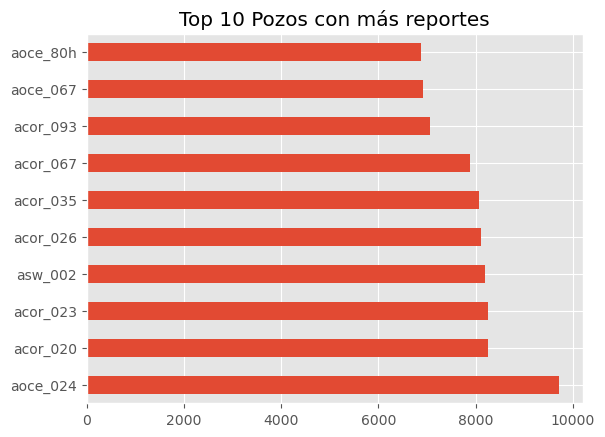

In [26]:
# Top 10 most reported 'pozos'
df['Pozo'].value_counts()[0:10].plot.barh()
plt.title("Top 10 Pozos con más reportes")

### Valor

Es el valor reportado para la variable, es de esperar que al ser variables diferentes, se tengan magnitudes diversas. Por ejemplo algunos valores representan porcentajes (0-100) mientas que otros pueden representar temperaturas o presiones. Por lo tanto podemos crear una tabla pivot en la cual separemos cada una de estas variables como columnas independientes. 

<Axes: xlabel='Value', ylabel='Count'>

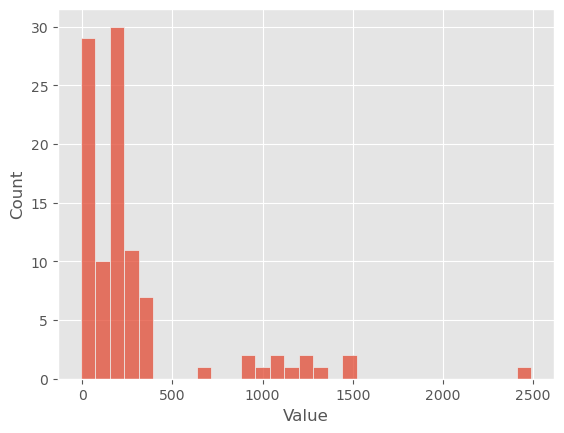

In [65]:
sns.histplot(x = "Value", data = df[0:100])

### Variable

Después de diversas reuniones con la compañía, nos proporcionaron un segundo archivo, que consta de las variables que manejan con su unidad de medida y nivel de importancia que ellos consideran para el analisis. 

In [28]:
pip install openpyxl --upgrade

Note: you may need to restart the kernel to use updated packages.


In [29]:
# Loading and showing a sample for main variables
main_variables_df = pd.read_excel('data/variables_cosmos.xlsx', sheet_name="Variables")
print(main_variables_df.shape)
main_variables_df.head(8)

(46, 3)


,Variable,Unidad,Importancia
0,AMP_MA.PV,A,0
1,AMP_S.PV,NaN,0
2,I_MOT,NaN,2
3,I_MOT.PV,NaN,2
4,I_OUT_VSD.PV,NaN,2
5,LOWER_I_MOT.PV,NaN,0
6,MOT_TORQ.PV,%,1
7,PUMP_FILL_MONITOR.PV,NaN,1


Podemos observar que la unidad de la variable solo aparece en el primer registro, por lo tanto vamos a solucionar esto usando la función *ffill*

In [30]:
# Fixing missing values in "Unidad"
main_variables_df = main_variables_df.fillna(method="ffill")
main_variables_df.head(8)

,Variable,Unidad,Importancia
0,AMP_MA.PV,A,0
1,AMP_S.PV,A,0
2,I_MOT,A,2
3,I_MOT.PV,A,2
4,I_OUT_VSD.PV,A,2
5,LOWER_I_MOT.PV,A,0
6,MOT_TORQ.PV,%,1
7,PUMP_FILL_MONITOR.PV,%,1


Con este nuevo archivo ya tenemos los datos sobre unidad de medida para cada variable.

Text(0.5, 1.0, 'Unidades de medida de las variables')

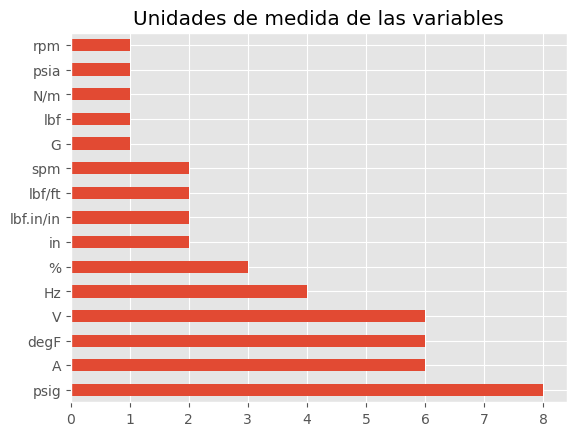

In [31]:
# Units
main_variables_df['Unidad'].value_counts().plot.barh()
plt.title("Unidades de medida de las variables")

Ahora bien, podemos comprobar que el orden de importancia sigue una escala de 0-2, siendo 2 una variable con mayor importancia para el negocio.

In [32]:
# Importance range
main_variables_df['Importancia'].unique()

array([0, 2, 1])

Text(0.5, 1.0, 'Variable vs Importancia')

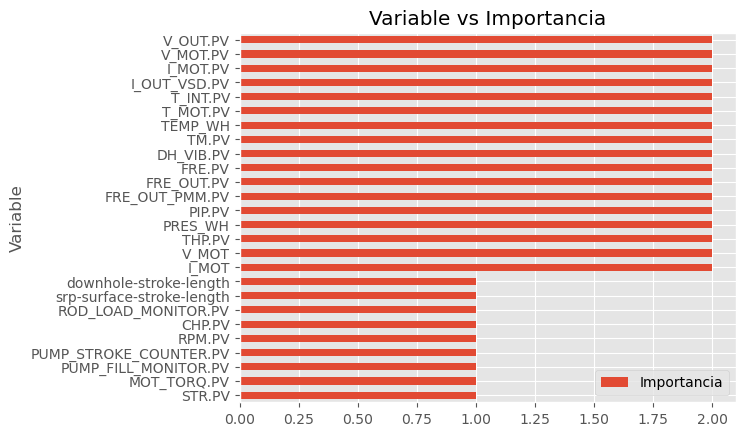

In [33]:
# Variables vs Importance level
main_variables_df[main_variables_df["Importancia"] > 0].sort_values('Importancia').plot.barh(x='Variable', y="Importancia")
plt.title("Variable vs Importancia")

In [34]:
# Main Variables
main_variables_df[main_variables_df['Importancia'] == 2]

,Variable,Unidad,Importancia
2,I_MOT,A,2
3,I_MOT.PV,A,2
4,I_OUT_VSD.PV,A,2
11,T_INT.PV,degF,2
12,T_MOT.PV,degF,2
13,TEMP_WH,degF,2
14,TM.PV,degF,2
15,DH_VIB.PV,G,2
16,FRE.PV,Hz,2
17,FRE_OUT.PV,Hz,2


Estas variables, con importancia mayor a 0, serán las únicas que utilizaremos en el dataset original.

In [35]:
# Upper case to lower case
main_variables_df['Variable'] = main_variables_df['Variable'].str.lower()

In [36]:
# Original variables vs Main variables relation
print("Variables importantes:", len(main_variables_df[main_variables_df['Importancia'] > 0]))
print("Variables originales:", len(df['Variable'].drop_duplicates()))

Variables importantes: 26
Variables originales: 92


In [37]:
# Filtering df by main variables
df = df[df['Variable'].isin(main_variables_df['Variable'])]
df.shape

(365392, 9)

Ahora podemos analizar cuáles son las variables más reportadas por el dispositivo IoT.

Text(0.5, 1.0, 'Top 10 most common Variables reported')

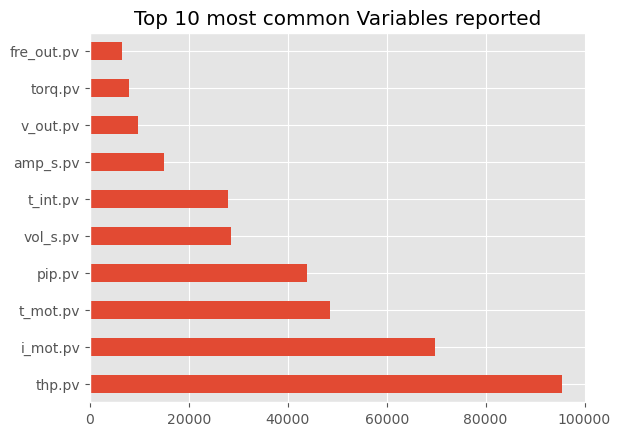

In [38]:
df['Variable'].value_counts()[0:10].plot.barh()
plt.title("Top 10 most common Variables reported")

## 3. Analisis Bi-Variado

### Value
#### Validación de tiempos:

Se encuentra que la información tiene hora desde las 00:00 hasta las 20:01. Se espera que la distribución de reportes sea similar entre todas las horas.

In [39]:
print(df['SourceTimestamp'].max())
print(df['SourceTimestamp'].min())


2023-09-14 20:01:02.000961
2023-09-14 00:00:23.101015


Se realiza un pivoteo de los datos para facilitar su  manejo al tener cada metrica/variable como una columna

In [40]:
pivot_table =  pd.pivot_table(df, values='Value', index=['Pozo', 'SourceTimestamp'],
                       columns=['Variable'], aggfunc="sum")
pivot_table = pivot_table.reset_index()
pivot_table

Variable,Pozo,SourceTimestamp,amp_s.pv,chp.pv,fre.pv,fre_out.pv,fre_out_pmm.pv,i_mot.pv,lower_fre_out.pv,lower_i_mot.pv,...,rpm.pv,str.pv,t_int.pv,t_mot.pv,thp.pv,torq.pv,torqlf.pv,v_mot.pv,v_out.pv,vol_s.pv
0,aegen_gua1_tr1,2023-09-14 03:05:12.100744,NaN,NaN,1.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,aegen_gua1_tr1,2023-09-14 03:07:50.500932,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,aegen_gua1_tr1,2023-09-14 03:08:41.800330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,aegen_gua1_tr1,2023-09-14 07:21:40.800405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,aegen_gua1_tr1,2023-09-14 07:21:58.500470,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321393,asw_44h,2023-09-14 19:49:27.801078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,171.064514,NaN,NaN,NaN,NaN,NaN
321394,asw_44h,2023-09-14 19:51:35.400386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,333.500000,NaN,NaN,NaN,NaN,NaN
321395,asw_44h,2023-09-14 19:53:44.800440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1034.100000,NaN,NaN,NaN,NaN,NaN
321396,asw_44h,2023-09-14 19:56:29.900443,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,645.000000,NaN,NaN,NaN,NaN,NaN


Inicialmente parece que existen muchos campos vacíos, se evaluará la cantidad de vacíos más adelante.

### Validación de cantidad de datos por hora

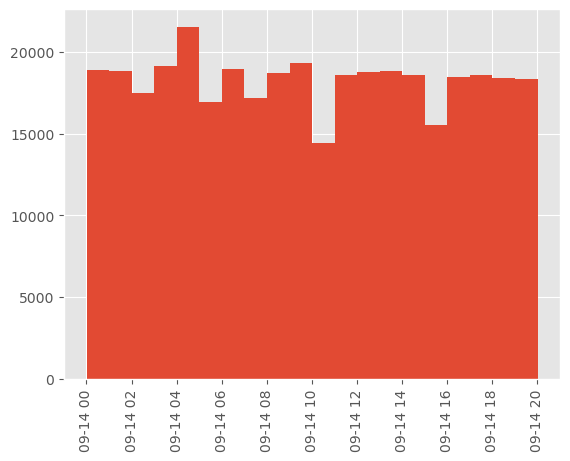

In [41]:
p = df['SourceTimestamp'].hist(bins=20)
plt.xticks(rotation='vertical')

plt.show()

La cantidad de datos parece ser la misma por hora con excepción de las 4 donde hay 2k reportes extra y de las 16 donde hay 2k reportes menos, sin embargo parece ser una distribución uniforme. se hace un test chi cuadrado para validar.

In [42]:
df.dtypes

NodeId                           object
Value                           float64
EventProcessedUtcTime    datetime64[ns]
EventEnqueuedUtcTime     datetime64[ns]
campo                            object
SourceTimestamp          datetime64[ns]
EnqueuedTime                     object
Pozo                             object
Variable                         object
dtype: object

In [43]:
def hour_f(ts):
    return ts.hour

In [67]:
df['hour']  = df['SourceTimestamp'].apply(hour_f)
hourly_counts = df.loc[df['hour']<20,'hour'].value_counts().sort_index()


observed_counts = hourly_counts.values
expected_counts = len(df[df['hour']<20]) / 20  # Assuming a uniform distribution

chi2, p = chisquare(observed_counts, f_exp=expected_counts)

if p < 0.001:
    print("Hourly counts are not uniform.")
else:
    print("Hourly counts are uniform.")

Hourly counts are not uniform.


/tmp/ipykernel_11232/2010206543.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour']  = df['SourceTimestamp'].apply(hour_f)


El resultado del test chi cuadrado indica que no es una distribución uniforme.
Se realiza el mismo conteo por algunas variables para identificar posibles cambios

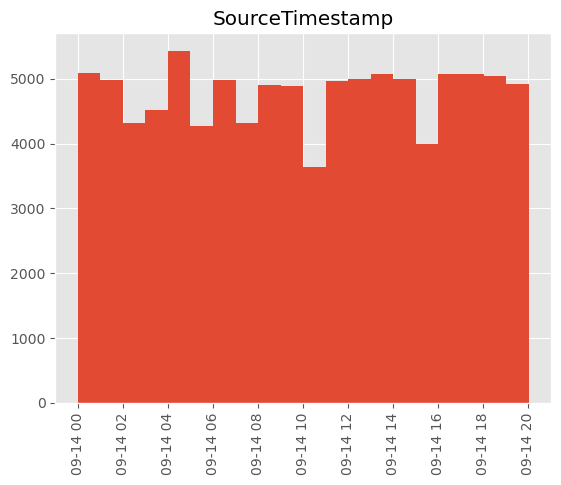

In [45]:
p = pivot_table.loc[~(pivot_table['thp.pv'].isnull()),['SourceTimestamp']].hist(bins=20)
plt.xticks(rotation='vertical')

plt.show()

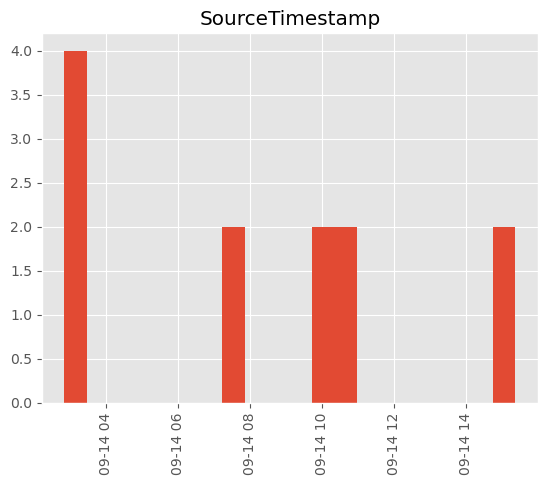

In [46]:
p = pivot_table.loc[~(pivot_table['fre.pv'].isnull()),['SourceTimestamp']].hist(bins=20)
plt.xticks(rotation='vertical')

plt.show()

In [47]:
pivot_table.loc[~(pivot_table['fre.pv'].isnull()),['Pozo']].Pozo.unique()

array(['aegen_gua1_tr1', 'aegen_gua2_tr1'], dtype=object)

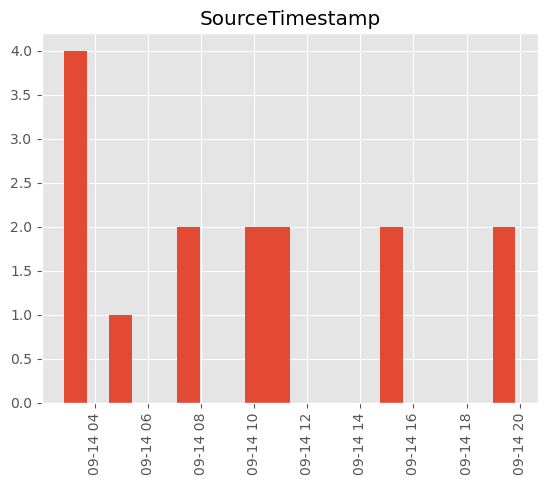

In [48]:
p = pivot_table.loc[~(pivot_table['rpm.pv'].isnull()),['SourceTimestamp']].hist(bins=20)
plt.xticks(rotation='vertical')

plt.show()

In [49]:
cols = pivot_table.columns.to_list()[2:14]
cols2 = pivot_table.columns.to_list()[15:]
colsf = pivot_table.columns.to_list()[2:]
print(len(cols))
print(len(cols2))

12
12


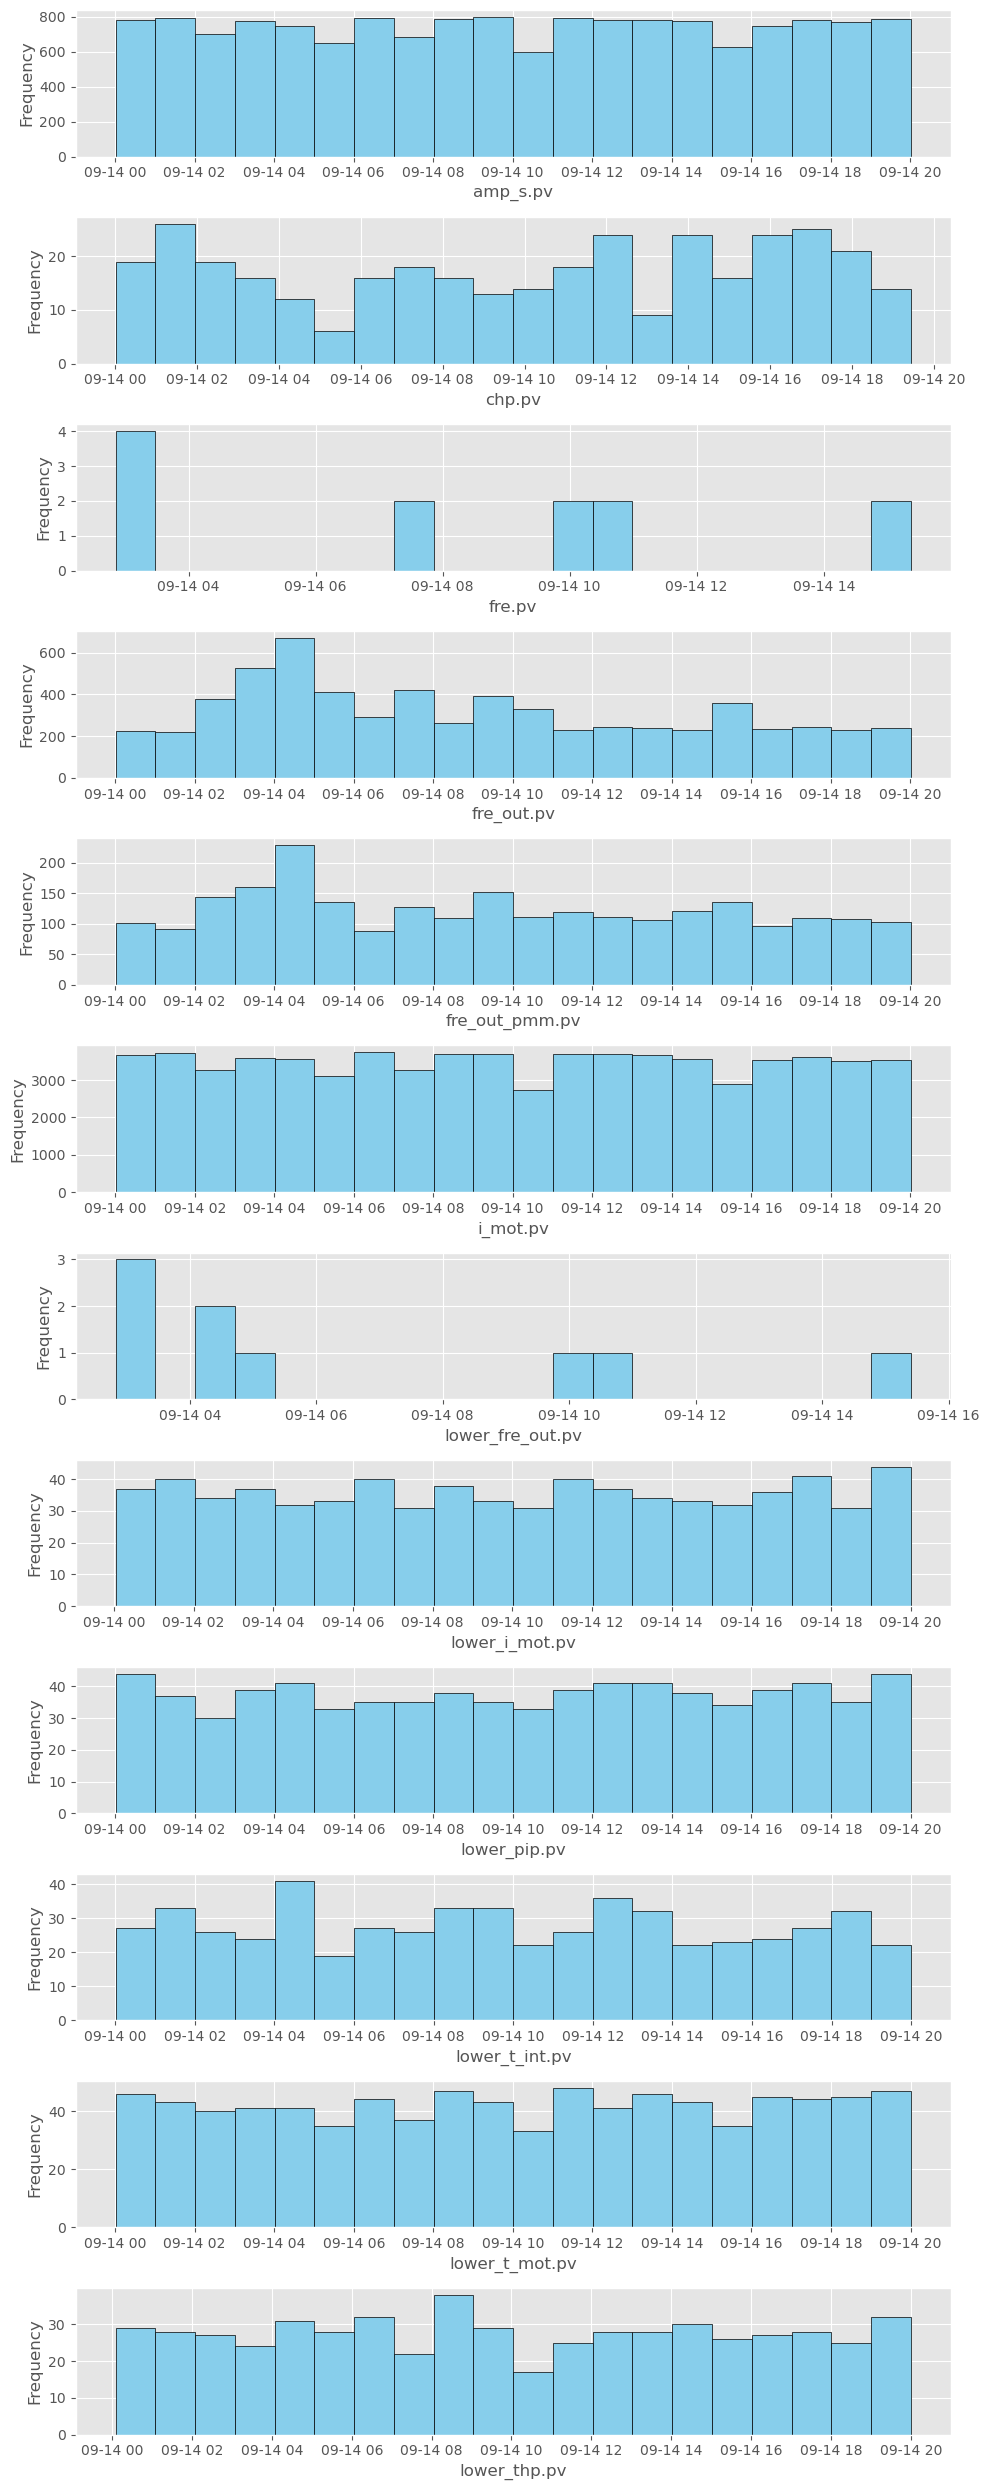

In [50]:
fig, axes = plt.subplots(12, 1, figsize=(10, 25))  # 12 rows, 1 column

# Iterate through the columns and create subplots
for i, column in enumerate(cols):
    ax = axes[i]  # Select the current subplot
    ax.hist(pivot_table.loc[~(pivot_table[column].isnull()),['SourceTimestamp']], bins=20, color='skyblue', edgecolor='black')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

# Adjust the layout to prevent overlapping labels
plt.tight_layout()

# Show the plot
plt.show()

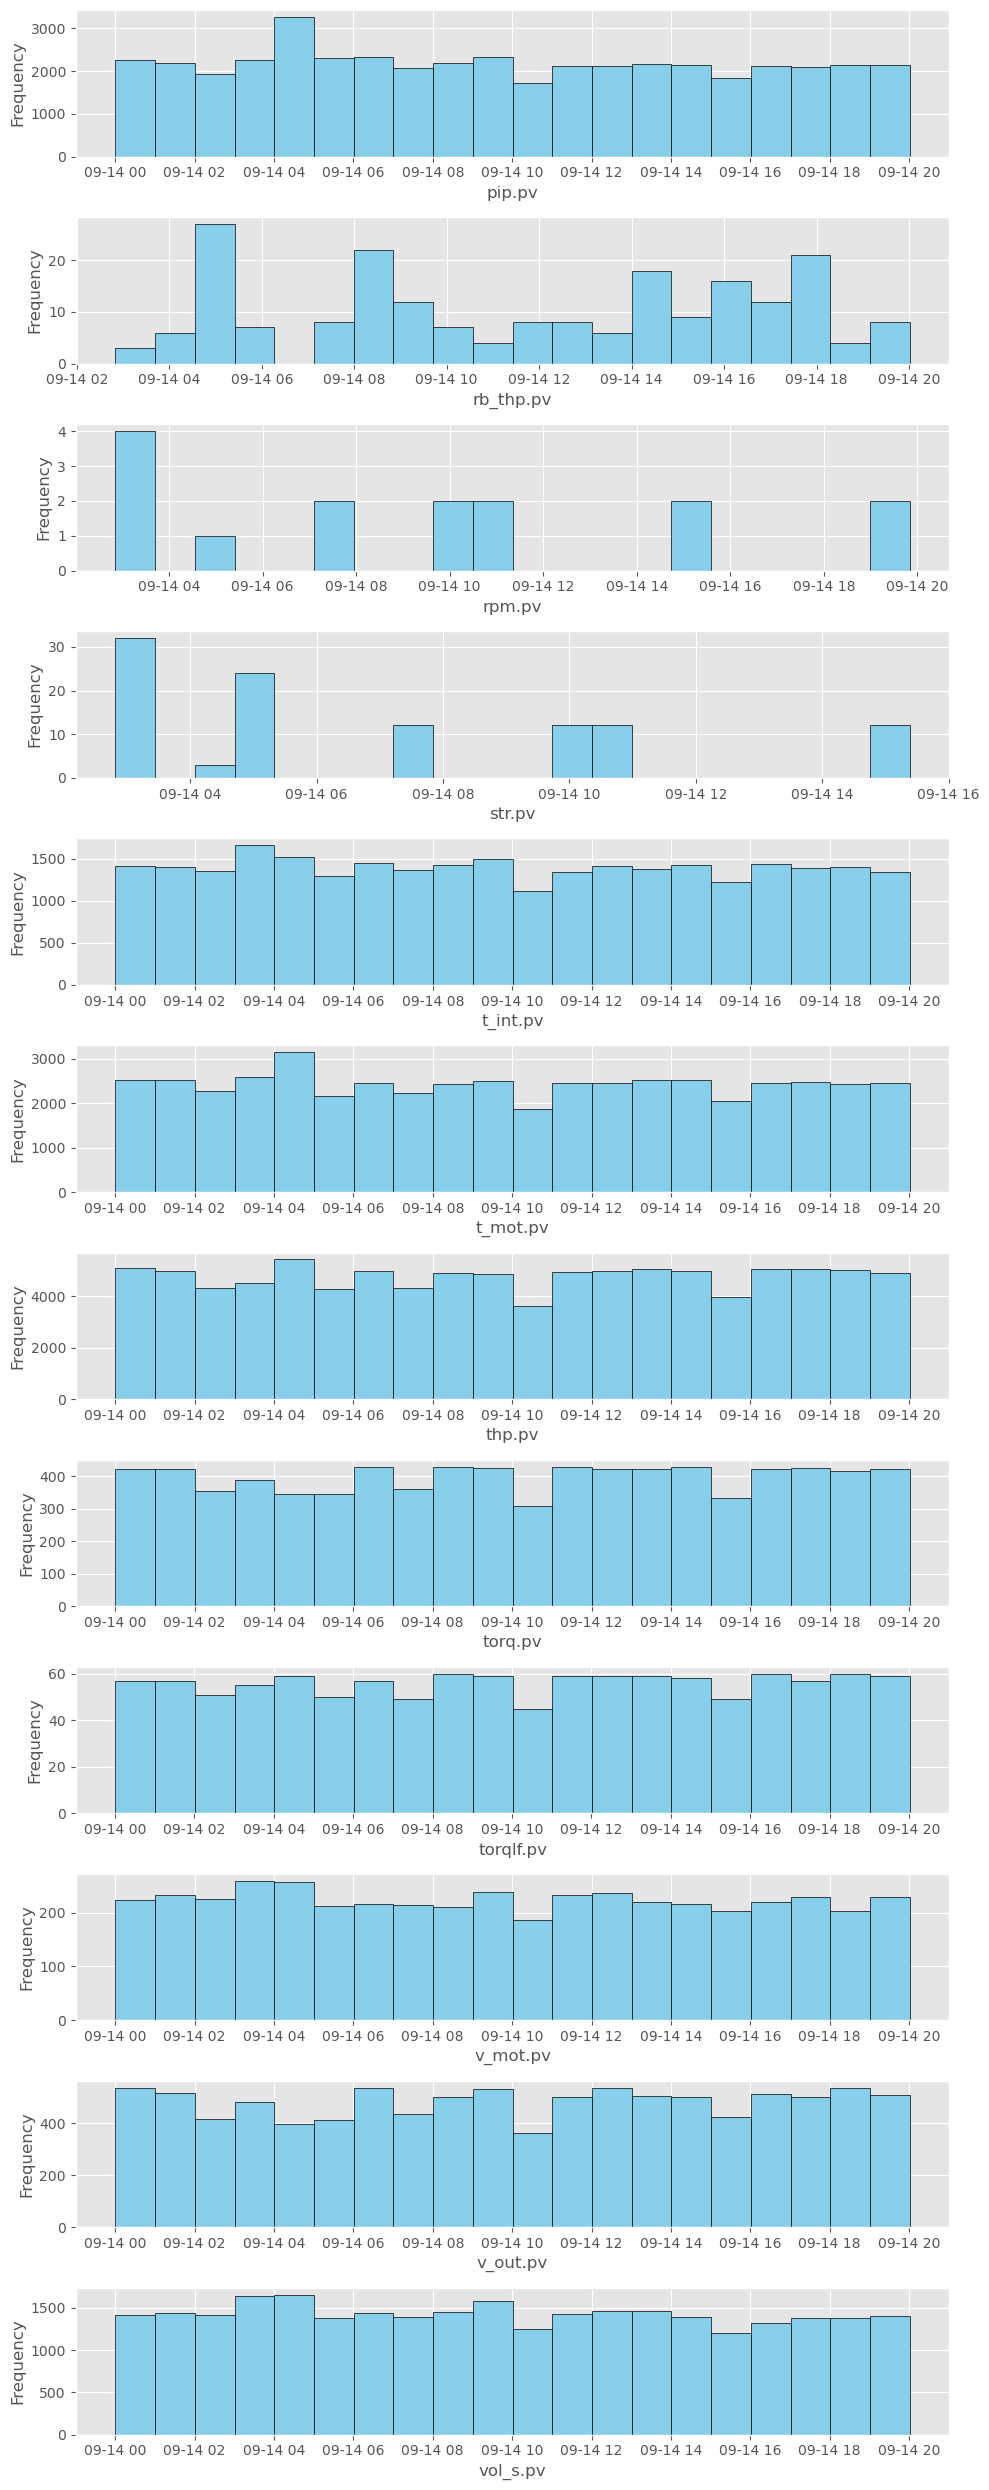

In [51]:
fig, axes = plt.subplots(12, 1, figsize=(10, 25))  # 12 rows, 1 column


for i, column in enumerate(cols2):
    ax = axes[i]  
    ax.hist(pivot_table.loc[~(pivot_table[column].isnull()),['SourceTimestamp']], bins=20, color='skyblue', edgecolor='black')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

plt.tight_layout()

plt.show()

Existen variaciones entre los distintos campos que pueden afectar la distribución de la muestra. Algunos están más regularizados que otros.

### Conteo de datos nulos

Se realiza un conteo de los datos nulos sobre la cantidad de registros:

In [52]:
print(pivot_table.isna().sum()/321398*100)
print('promedio de porcentaje vacío: '+ str((pivot_table.isna().sum()/321398*100)[2:].mean()))


Variable
Pozo                 0.000000
SourceTimestamp      0.000000
amp_s.pv            95.344713
chp.pv              99.891101
fre.pv              99.996266
fre_out.pv          98.018034
fre_out_pmm.pv      99.232416
i_mot.pv            78.302914
lower_fre_out.pv    99.997200
lower_i_mot.pv      99.777846
lower_pip.pv        99.766022
lower_t_int.pv      99.827317
lower_t_mot.pv      99.737397
lower_thp.pv        99.827628
lower_vol_s.pv      99.997511
pip.pv              86.383549
rb_thp.pv           99.935905
rpm.pv              99.995333
str.pv              99.966708
t_int.pv            91.323219
t_mot.pv            84.936745
thp.pv              70.294775
torq.pv             97.522075
torqlf.pv           99.651834
v_mot.pv            98.612001
v_out.pv            96.997803
vol_s.pv            91.119422
dtype: float64
promedio de porcentaje vacío: 95.4582293604814


Existen demasiado campos sin información y es en promedio un 95.45%

In [53]:
nan_count = pivot_table.isna().sum(axis=1)
nan_count.describe()

count    321398.000000
mean         23.864557
std           0.455129
min          16.000000
25%          24.000000
50%          24.000000
75%          24.000000
max          24.000000
dtype: float64

Se crea una tabla sin la hora para verificar si sigue existiendo esa discrepancia:

In [54]:
pivot_table_no_hour =  pd.pivot_table(df, values='Value', index=['Pozo'],
                       columns=['Variable'], aggfunc="mean")
pivot_table_no_hour = pivot_table_no_hour.reset_index()
pivot_table_no_hour

Variable,Pozo,amp_s.pv,chp.pv,fre.pv,fre_out.pv,fre_out_pmm.pv,i_mot.pv,lower_fre_out.pv,lower_i_mot.pv,lower_pip.pv,...,rpm.pv,str.pv,t_int.pv,t_mot.pv,thp.pv,torq.pv,torqlf.pv,v_mot.pv,v_out.pv,vol_s.pv
0,aegen_gua1_tr1,NaN,NaN,12815.094752,NaN,NaN,NaN,NaN,NaN,NaN,...,80.715910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,aegen_gua2_tr1,NaN,NaN,83.143731,NaN,NaN,NaN,NaN,NaN,NaN,...,131.211111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,agua_001,NaN,NaN,NaN,141.262935,6500.982928,3.474239e+15,NaN,NaN,NaN,...,NaN,NaN,1.056143e+02,-3.414926e+34,-1.803275e+13,NaN,NaN,NaN,NaN,-7.241137e+25
3,agua_004,NaN,NaN,NaN,195.925453,3158.040832,1.101265e+35,NaN,NaN,NaN,...,NaN,NaN,1.066433e+02,2.050239e+03,1.508970e+03,NaN,NaN,NaN,NaN,6.567570e+28
4,agua_006,NaN,NaN,NaN,179.907143,NaN,4.798813e+01,NaN,NaN,NaN,...,NaN,NaN,5.305267e+01,1.604952e+02,NaN,NaN,NaN,NaN,NaN,4.256893e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,asw_39h,NaN,NaN,NaN,13564.412914,NaN,-8.518535e+28,NaN,NaN,NaN,...,NaN,NaN,7.436508e+02,-8.840389e+14,2.188277e+27,NaN,NaN,NaN,NaN,2.180721e+32
190,asw_41h,774.911858,NaN,NaN,749.278284,NaN,6.760178e+01,NaN,NaN,NaN,...,NaN,NaN,3.268168e+02,2.691945e+04,8.764509e+02,NaN,NaN,274.299455,NaN,7.863514e+01
191,asw_42h,335.506527,NaN,NaN,3087.017130,NaN,7.753773e+02,NaN,NaN,NaN,...,NaN,NaN,3.001944e+02,5.711124e+22,-7.033836e+21,NaN,NaN,320.096955,NaN,2.801701e+03
192,asw_43h,65.063539,NaN,NaN,293.351826,7850.071094,1.386345e+02,NaN,NaN,NaN,...,NaN,NaN,7.348638e+28,9.773947e+04,-8.674953e+32,NaN,NaN,162.344344,NaN,2.330889e+02


In [55]:
pivot_table_no_hour.isnull().sum()/194*100

Variable
Pozo                 0.000000
amp_s.pv            83.505155
chp.pv              99.484536
fre.pv              98.969072
fre_out.pv           7.216495
fre_out_pmm.pv      76.288660
i_mot.pv             7.216495
lower_fre_out.pv    99.484536
lower_i_mot.pv      99.484536
lower_pip.pv        99.484536
lower_t_int.pv      99.484536
lower_t_mot.pv      99.484536
lower_thp.pv        99.484536
lower_vol_s.pv      99.484536
pip.pv               6.701031
rb_thp.pv           99.484536
rpm.pv              98.969072
str.pv              93.814433
t_int.pv             7.731959
t_mot.pv             8.247423
thp.pv              22.680412
torq.pv             95.876289
torqlf.pv           98.969072
v_mot.pv            85.051546
v_out.pv            95.360825
vol_s.pv             7.216495
dtype: float64

In [56]:
cols

['amp_s.pv',
 'chp.pv',
 'fre.pv',
 'fre_out.pv',
 'fre_out_pmm.pv',
 'i_mot.pv',
 'lower_fre_out.pv',
 'lower_i_mot.pv',
 'lower_pip.pv',
 'lower_t_int.pv',
 'lower_t_mot.pv',
 'lower_thp.pv']

Aún de esta manera existen demasiados pozos sin campos enteros de información. Es importante preguntar a negocio si la información llega cuando se presentan cambios o si debería llegar consistentemente.

A nivel de variable se revisan y se saca la distribución excluyendo los outliers:

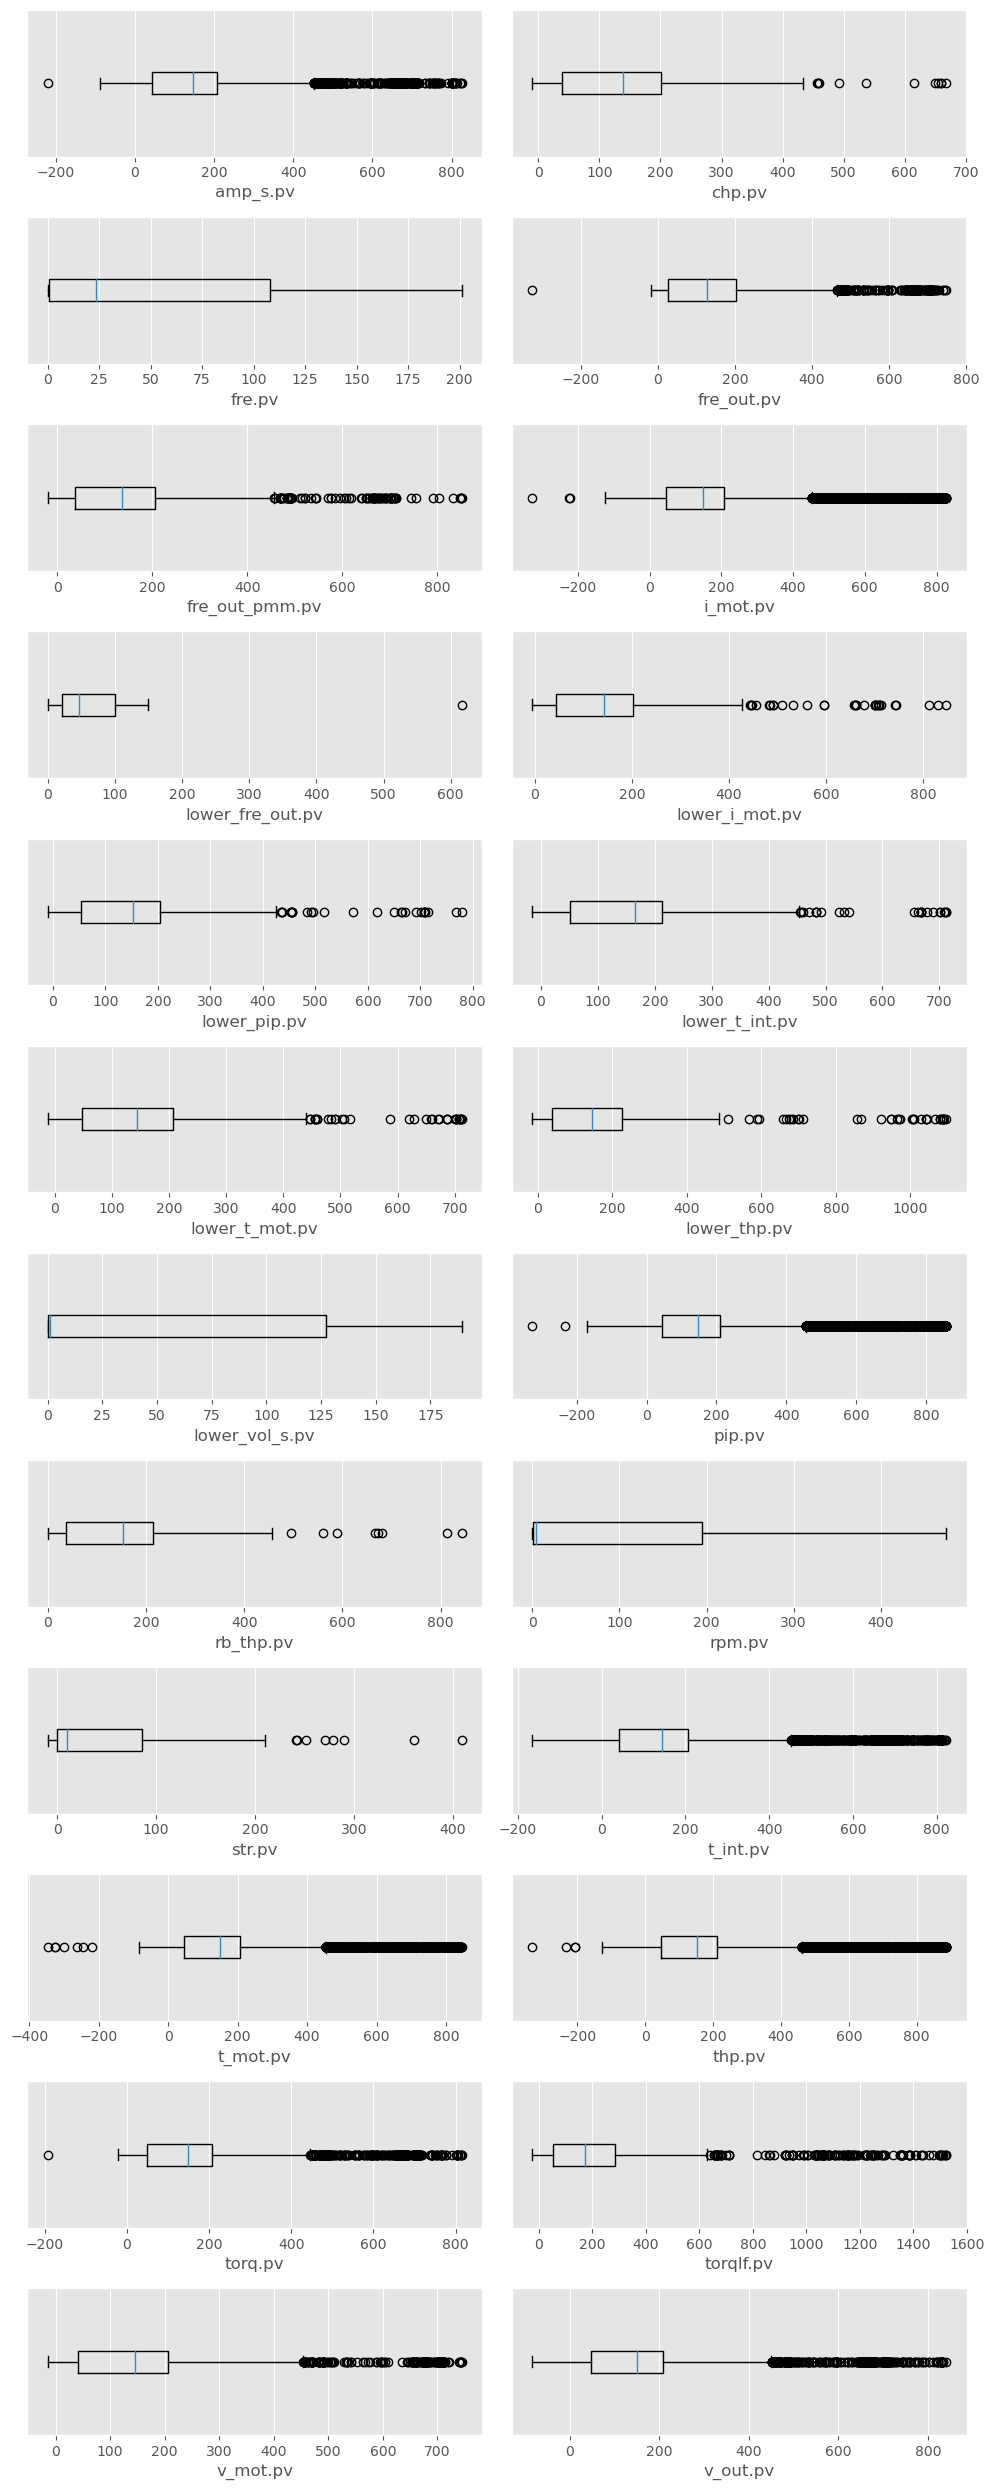

In [57]:
fig, axes = plt.subplots(12, 2, figsize=(10, 25))  # 12 rows, 1 column

k=0
p=0

for j in range(12):
    for k in range(2):
        
        col = colsf[p]
        #Cálculo de los límites para cada col
        q1 = pivot_table[colsf[p]].quantile(0.25)
        q3 = pivot_table[colsf[p]].quantile(0.75)
        iqr = q3 - q1

        upper_limit = q3 + 1.5 * iqr
        lower_limit = q1 - 1.5 * iqr


        ax = axes[j,k]  


        ax.boxplot(pivot_table.loc[~(pivot_table[col].isnull())&(pivot_table[col]>= lower_limit)&(pivot_table[col]<upper_limit),[col]][col], vert=False)
        ax.set_xlabel(col)
        ax.set_yticks([])  # Remove y-axis ticks to save space

        p=p+1

plt.tight_layout()

plt.show()




En algunos casos se ven mediciones negativas incluso cuando las unidades no lo soportan. Es necesario validar con negocio si estos números son correctos o las unidades están correctas.

También se eliminaron outliers demasiado grandes que afectaban la metrica.

Por último se realiza una matrix de correlación para verificar posibles correlaciones. Es importante aclarar que al tener tan pocos registros algunas variables, podría no estar correcto:


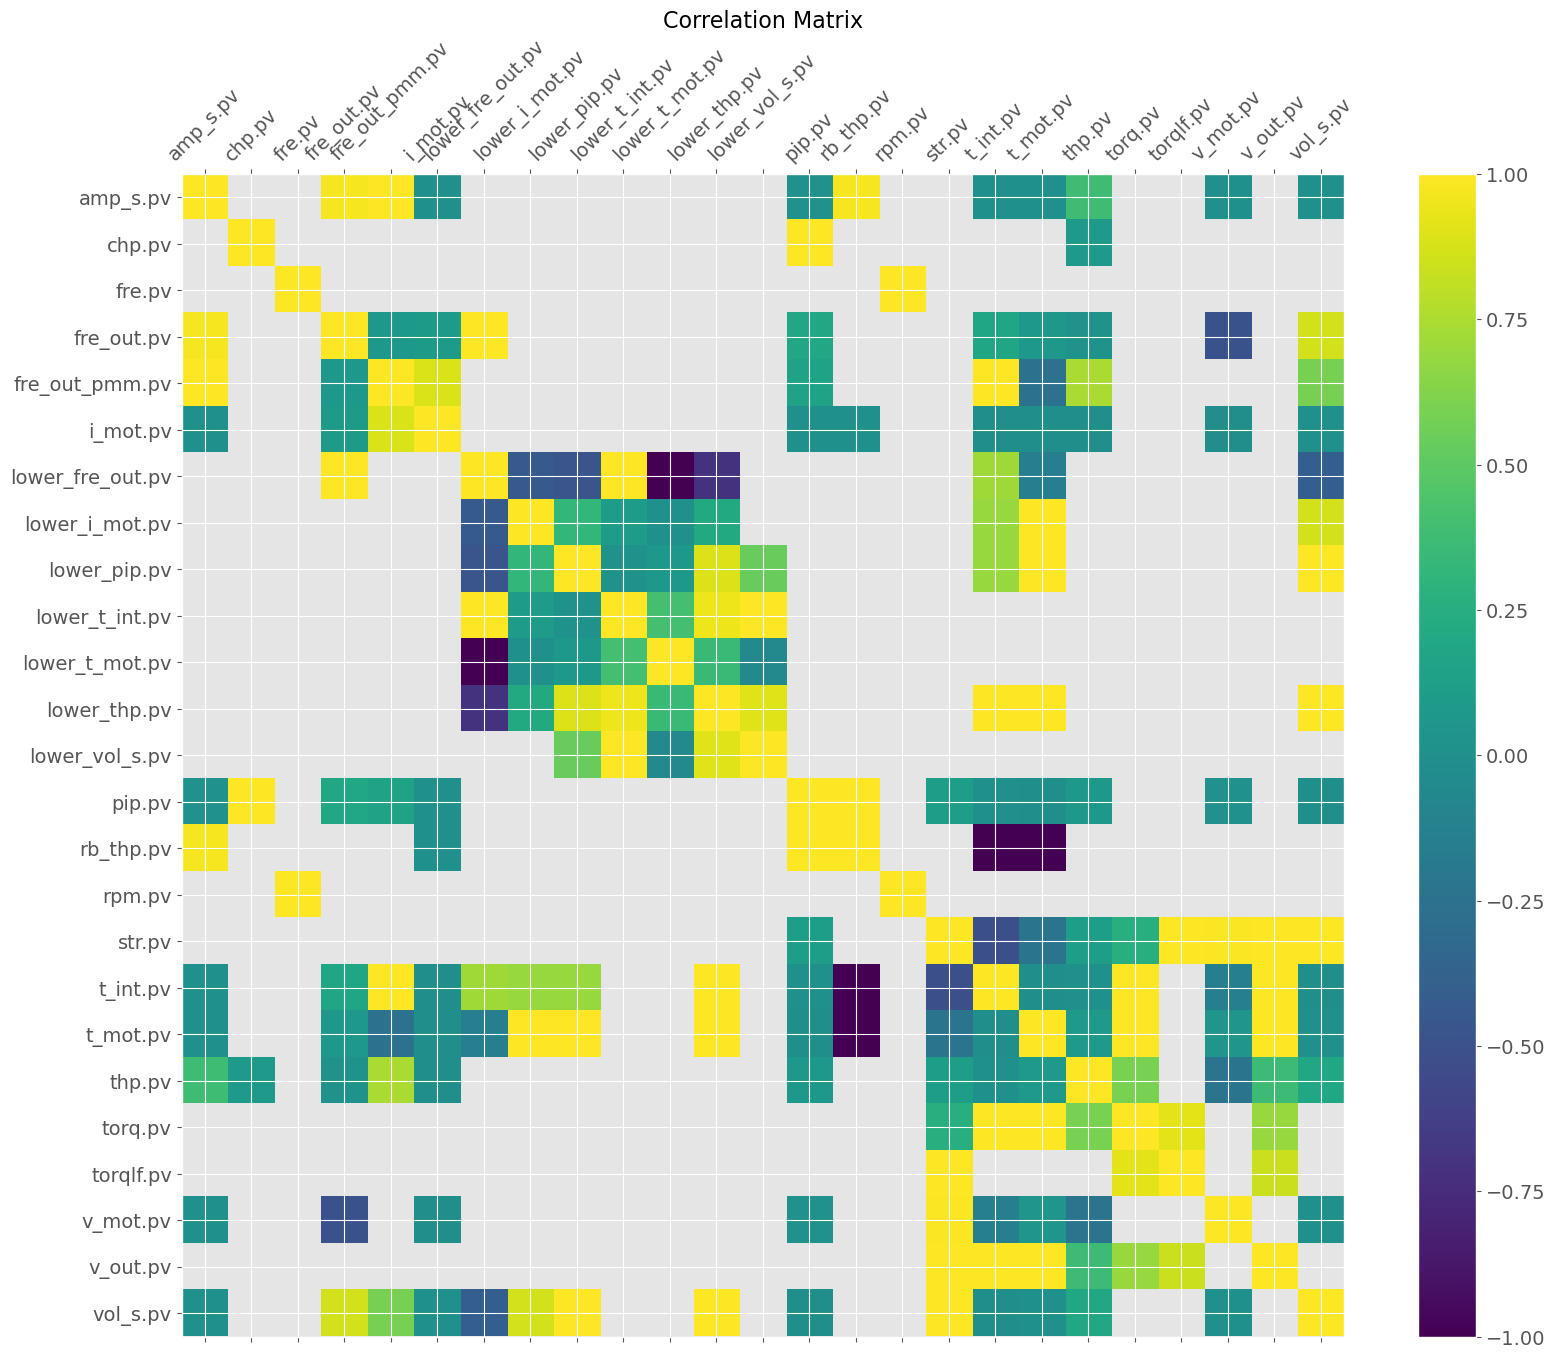

In [58]:
f = plt.figure(figsize=(19, 15))

plt.matshow(pivot_table[pivot_table.select_dtypes(['number']).columns.tolist()].corr(), fignum=f.number)
plt.xticks(range(pivot_table.select_dtypes(['number']).shape[1]), pivot_table.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(pivot_table.select_dtypes(['number']).shape[1]), pivot_table.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

plt.title('Correlation Matrix', fontsize=16);

parecen existir algunas correlaciones fuertescomo fre_out.pv con amp_s. sin embargo es importante verificar la validez de los datos con negocio antes de tomar esto como cierto.

# 4. Resumen:

* La distribución de registros por hora no es uniforme (prueba chi cuadrado)
* Existe una gran cantidad de valores nulos, esto puede deberse a que el sensor reporta únicamente al momento de presentarse cambios **(Se requiere validar con negocio)**
* Algunas de las métricas se recuperan muy pocas veces para ser tenidas en cuenta.
* Se encuentran algunos valores negativos incluso cuando las unidades no lo permiten **(Validar con el negocio)**
* Existen algunas posibles correlaciones entre variables pero es necesario asegurar que los datos con los que se dispone muestran la información correcta.
* Existen outliers muy grandes o muy pequeños que superan las medias en ordenes de magnitud.